In [0]:
#pip install -U git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git
#!python -m spacy download es

SyntaxError: ignored

In [2]:
!python -m spacy download es

     |████████████████████████████████| 11.1MB 1.8MB/s 
  Created wheel for es-core-news-sm: filename=es_core_news_sm-2.1.0-cp36-none-any.whl size=11111556 sha256=053763641ca384dc59e6e46bb9b82ef4f3fe33a442220eeb8f3a51cd3b0ffd25
  Stored in directory: /tmp/pip-ephem-wheel-cache-w0wam6qi/wheels/cc/ee/c4/68922955901918a9aaa82e828d4f7ee1ccfc861285277e79b7
Successfully built es-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('es_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/es_core_news_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/es
You can now load the model via spacy.load('es')


In [0]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud_2020 #pip install -U git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git

#All these packages need to be installed from pip

#This will be doing most of the work
import networkx as nx

import sklearn #For generating some matrices
import pandas as pd #For DataFrames
import numpy as np #For arrays
import matplotlib.pyplot as plt #For plotting
import seaborn #Makes the plots look nice
import scipy #Some stats
import nltk #a little language code
from IPython.display import Image #for pics

import pickle #if you want to save layouts
import os

from os import listdir
from os.path import isfile, join

# comp-linguistics
import spacy
import nltk
from spacy import displacy
#Using NLP in spanish
nlp = spacy.load("es")

%matplotlib inline


###**Exercise 1**  
Construct cells immediately below this that render networks to meaningfully characterize the structure of words and documents (or subdocuments like chapters or paragraphs) from your corpus. What are useful filters and thresholds and what semantic structures do they reveal that give insight into the social world and social game inscribed in your corpus? Interrogate interesting subgraphs of your network and detail what they reveal about the semantic space involved.

For the folowing homework i will be using the presidential speeches database from the last 19 years in Peru. First, we will construct the matrix of words that are created as a way to represent the network.

In [0]:
def word_tokenize(word_list):
    tokenized = []
    # pass word list through language model.
    doc = nlp(word_list)
    for token in doc:
        if not token.is_punct and len(token.text.strip()) > 0:
            tokenized.append(token.text)
    return tokenized

def wordCooccurrence(sentences, makeMatrix = False):
    words = set()
    for sent in sentences:
        words |= set(sent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in sentences:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        return g

In [0]:
text_folder = '/content/txt'
text_dic = {}
onlyfiles = [f for f in listdir(text_folder) if isfile(join(text_folder, f))]

for file in onlyfiles:
    f = open(text_folder + '/' + file, "r")
    text_dic[file] = {}
    text_dic[file]['name'] = file
    text_dic[file]['text'] = f.read()
    
#Using the modified version of clean_raw_text function, incorporating it into my own code, we build 
#the lists of tokenized texts for every speech
for index, data in text_dic.items():
    text_dic[index]['clean_text'] = text_dic[index]['text'].replace(" \'m", "'m") \
        .replace(" \'ll", "'ll").replace(" \'re", "'re") \
        .replace(" \'s", "'s").replace(" \'re", "'re")\
        .replace("\n", "").replace("\x0c", "")
    text_dic[index]['token_word_list'] = word_tokenize(text_dic[index]['clean_text'])

In [0]:
df_text = pd.DataFrame(text_dic)
df_text = df_text.T 

I am using the clean text for tokenizing the sentences. One important caveat of this project is that is in spanish, and there's an issue regarding the tokenization of sentences in spanish. I've been researching that the training models for doing this categorization are not performing so go as in English, so we are looking for better ways in doing so. 

In [0]:
df_text['tokenized_sents'] = df_text['clean_text'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
df_text['normalized_sents'] = df_text['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s) for s in x])

In [10]:
print(len(df_text['normalized_sents'][11:12].sum()))
print(len(df_text['normalized_sents'][:10].sum()))
print(len(df_text['normalized_sents'][:11].sum()))

2120
28650
31080


Building the network with all the possible sentences. 

In [0]:
g = wordCooccurrence(df_text['normalized_sents'].sum())

In [0]:
g

In [12]:
len(g.nodes)

13467

In [13]:
len(g.edges)

220252

In [14]:
nx.to_numpy_matrix(g)[:10, :10]

matrix([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [15]:
mat = nx.to_numpy_matrix(g)
mat.shape

(13467, 13467)

In [0]:
def tokenize(text):
    tokenlist = lucem_illud_2020.word_tokenize(text)
    normalized = lucem_illud_2020.normalizeTokens(tokenlist)
    return normalized
import sklearn.feature_extraction


We first create a matrix of words by sentences

In [0]:
senVectorizer = sklearn.feature_extraction.text.CountVectorizer(tokenizer = tokenize)
senVects_incidence = senVectorizer.fit_transform(df_text['clean_text'])
#print(senVects_incidence.toarray())
#print(senVectorizer.get_feature_names()[:90])


In [18]:
len(senVectorizer.get_feature_names())

13912

In [19]:
senVects_incidence.shape

(19, 13912)

Then we create the network we will analyze. We will use bipartite graphs where two different sets of nodes will be used: The words and the docs. We then add the edges from one set to the other:

In [0]:
g_2mode = nx.Graph()

#define all the nodes
g_2mode.add_nodes_from((senVectorizer.get_feature_names()[i] for i in range(senVects_incidence.shape[1])), bipartite = 'word')
g_2mode.add_nodes_from(range(senVects_incidence.shape[0]), bipartite = 'doc')

#add all the edges
g_2mode.add_edges_from(((d, senVectorizer.get_feature_names()[w], {'weight' : senVects_incidence[d, w]}) for d, w in zip(*senVects_incidence.nonzero())))

In [21]:
print(nx.info(g_2mode))

Name: 
Type: Graph
Number of nodes: 13931
Number of edges: 41591
Average degree:   5.9710


Drawing the network, we see that we don't ge nothing out of it. Another interesting part of the project would be to see just how documents by a same author 

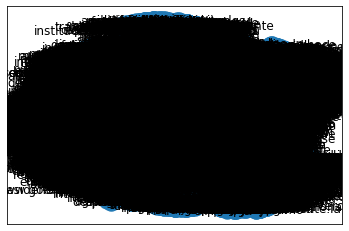

In [22]:
nx.draw_networkx(g_2mode)

In [0]:
def contractNetwork(g, targetType):
    g_mono = nx.Graph()
    g_mono.add_nodes_from(((n, d) for n, d in g.nodes(data = True) if d['bipartite'] == targetType))
    
    for n_outside in (n for n, d in g.nodes(data = True) if d['bipartite'] != targetType):
        neighbors = list((n for n in g.neighbors(n_outside) if g.nodes[n]['bipartite'] == targetType))
        for i, n1 in enumerate(neighbors):
            for n2 in neighbors[i+1:]:
                try:
                    g_mono.edges[n1, n2]['weight'] += 1
                except KeyError:
                    g_mono.add_edge(n1, n2, weight = 1)
    return g_mono

In [0]:
gDoc = contractNetwork(g_2mode, 'doc')

In [25]:
print(nx.info(gDoc))

Name: 
Type: Graph
Number of nodes: 19
Number of edges: 171
Average degree:  18.0000


When taking a look at the network of documentswe see that there are some that are at the center of the discourse, while there are other that are at more marginal positions. While we evidence clear patterns here, we will visualize the relations better when weighting the edges

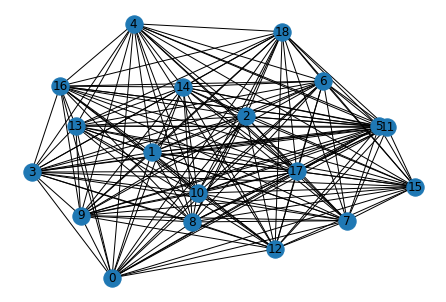

In [26]:
layout = nx.spring_layout(gDoc, k = 1/3, weight='weight', iterations= 50)
nx.draw(gDoc, pos = layout, labels = {n:n for n in gDoc.nodes()}) #Getting labels is a bit annoying

Here we see that the most important nodes are the 10th and the 8th, while the less connected ones are the 18, 4, 16 and 0, which are, in order, from Pedro Pablo Kunchinski, Ollanta Humala , Alejandro Toledo and  Alejandro Toledo.
Taking a look at who is in the center of the network (10 and 17), we also see Ollanta Humala (2015) and Alan Garcia (2008)

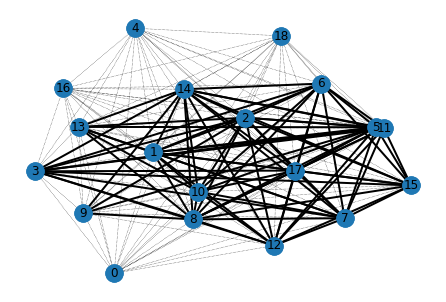

In [27]:
wMedian = np.median([d['weight'] for n1, n2, d in gDoc.edges(data = True)])
edgesHigh = [(n1, n2) for n1, n2, d in gDoc.edges(data = True) if d['weight'] > wMedian]
edgesLow = [(n1, n2) for n1, n2, d in gDoc.edges(data = True) if d['weight'] <= wMedian]
nx.draw(gDoc, pos = layout, labels = {n:n for n in gDoc.nodes()}, edgelist = edgesLow, style='dotted', width=.5)
nx.draw(gDoc, pos = layout, nodelist=None, edgelist = edgesHigh, width=2)

In [65]:
print(len(df_text.iloc[17]['text']),"words:","\n",df_text.iloc[17]['text'].strip().replace('  ', '\n')[:1000])

70673 words: 
 MENSAJE DEL PRESIDENTE CONSTITUCIONAL DEL PERÚ, 

DOCTOR ALAN GARCÍA PÉREZ, 

ANTE EL CONGRESO NACIONAL, EL 28 DE JULIO DE 20081 

la 

impulso
material,
nos
proponemos
profundizar 

 
 
Señor Presidente del Congreso, 
Señoras y señores Congresistas, 
Compatriotas en todos los hogares del Perú: 
 
Al
comenzar
el 
tercer
año
de
mi
gobierno,
cumplo
con
el
mandato 
constitucional
de
entregar
al
Congreso
el
informe
sobre
la
situación
de
la 
República y me dirijo al pueblo peruano para exponer los avances logrados, los 
problemas
surgidos
y
las
labores
por
cumplir.
Hablo
especialmente
a
la 
juventud, que espera todo de su lucha, de su esfuerzo y de su mérito. 
 
Expreso
mi
confianza
en
que
el
Perú
continuará
avanzando
de
manera 
dinámica y moderna, a pesar de sus contradicciones y dificultades. Mi mensaje 
será de optimismo y serenidad, y anuncio que, en este tercer año, luego de un 
gran 
redistribución, 
aumentando los recursos de la lucha contra la extrema pobreza y el núm

In [0]:
#print(len(df_text.iloc[16]['text']),"words:","\n",df_text.iloc[6]['text'].strip().replace('  ', '\n'))

We see that there are many nodes and even more edges, for the word set of nodes. To evidence their relations bettr, we contract our network so we only get the ones that have 100 or more weighted edges. 

In [28]:
gWord = contractNetwork(g_2mode, 'word')
print(nx.info(gWord))

Name: 
Type: Graph
Number of nodes: 13912
Number of edges: 28862656
Average degree: 4149.3180


In [29]:
wMean = np.mean([d['weight'] for n1, n2, d in gWord.edges(data = True)])
wMean

1.655016676219957

In [0]:
g = wordCooccurrence(df_text['normalized_sents'].sum())

In [31]:
len(g)

13467

In [0]:
g.remove_edges_from([(n1, n2) for n1, n2, d in g.edges(data = True) if d['weight'] <= 100])

In [0]:
g.remove_nodes_from(list(nx.isolates(g))) #since we are changing the graph list() evaluates the isolates first

In [0]:
def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)

In [35]:
giant = max(connected_component_subgraphs(g), key=len) # keep just the giant connected component
print(nx.info(giant))

Name: 
Type: Graph
Number of nodes: 85
Number of edges: 277
Average degree:   6.5176


Given that the unit of analysis are normalized sentences, we still have a lot of word connectors like y, de, que, los, se, la, at the center of the net. It is still interesting which other words besides the stop words ones are still at the center of the discourse: Peru, anho, gobierno. 

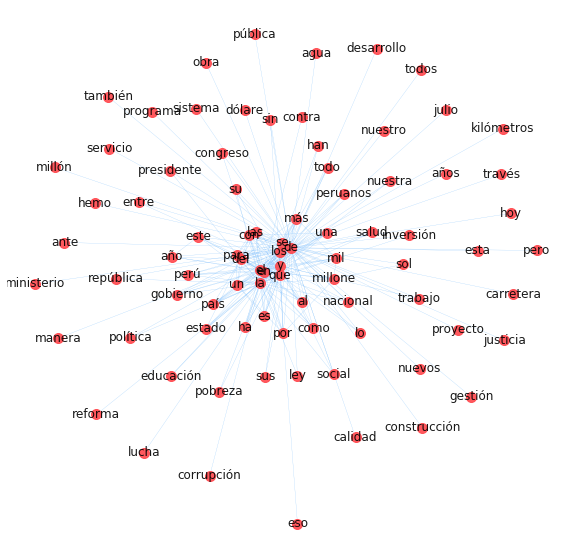

In [36]:
layout = nx.spring_layout(giant, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue') #Getting labels is a bit annoying

In [0]:
from networkx.algorithms.community import greedy_modularity_communities
c = list(greedy_modularity_communities(giant))

In [0]:
giant = nx.Graph(giant)

In [40]:
giant.remove_nodes_from([n for n in giant.nodes if len(set(giant.neighbors(n))) >= 2000]) 
giant.remove_nodes_from(list(nx.isolates(giant)))
print(nx.info(giant))

Name: 
Type: Graph
Number of nodes: 85
Number of edges: 277
Average degree:   6.5176


Checking another way of dropping nodes

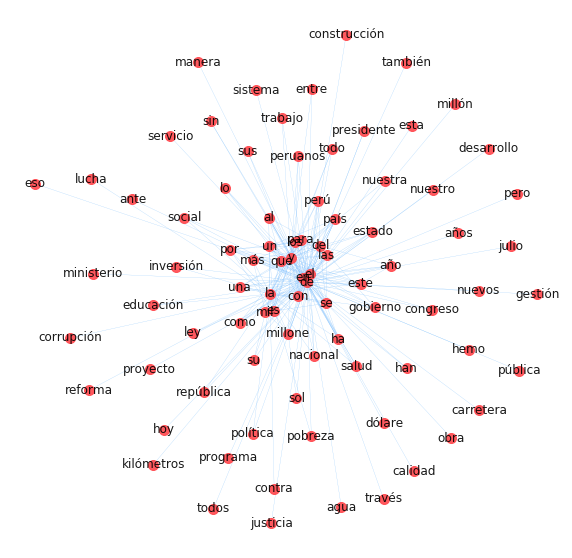

In [41]:
layout = nx.spring_layout(giant, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue') #Getting labels is a bit annoying

The following examines the subgraph for the word gobierno, or emergency, and the words that are in their inmediate and non-inmediate neighborhood.

In [96]:
gobiernoNeighbors = gWord.neighbors('gobierno')
gobiernoNeighborsPlus1 = set(gobiernoNeighbors)
for n in gobiernoNeighbors:
    gobiernoNeighborsPlus1 |= set(giant.neighbors(n))
    
#for x in gobiernoNeighborsPlus1:
#    print(x)


g_gobierno = giant.subgraph(gobiernoNeighbors)
print(nx.info(g_gobierno))

Name: 
Type: Graph
Number of nodes: 0
Number of edges: 0



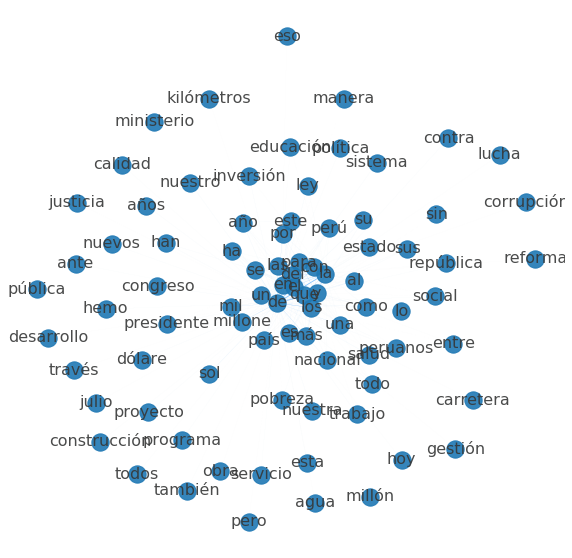

In [94]:

layout_amer = nx.spring_layout(g_gobierno, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (10,10))
maxWeight = max((d['weight'] for n1, n2, d in g_gobierno.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_gobierno.edges(data = True)))
nx.draw(g_gobierno, ax = ax, pos = layout_amer, labels = {n:n for n in g_gobierno.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_gobierno.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        cmap = plt.get_cmap('plasma'))


In [97]:
g_gobierno2 = giant.subgraph(gobiernoNeighborsPlus1)
print(nx.info(g_gobierno2))

Name: 
Type: Graph
Number of nodes: 84
Number of edges: 272
Average degree:   6.4762


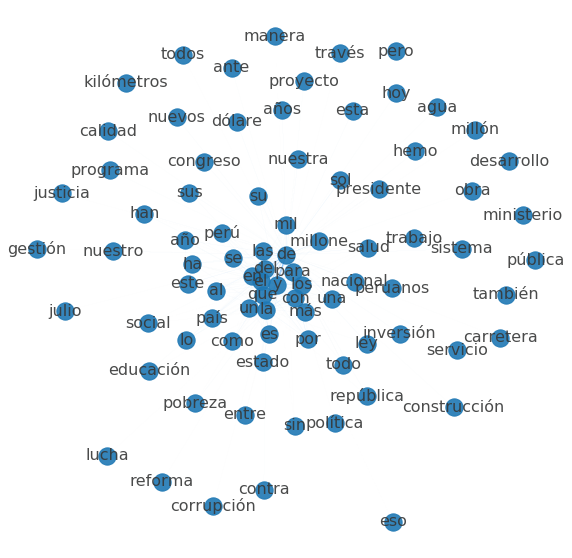

In [98]:
layout_amer = nx.spring_layout(g_gobierno2, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (10,10))
centralities_amer = nx.eigenvector_centrality(g_gobierno2)
maxC = max(centralities_amer.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in g_gobierno2.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_gobierno2.edges(data = True)))
nx.draw(g_gobierno2, ax = ax, pos = layout_amer, labels = {n:n for n in g_gobierno2.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_gobierno2.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        cmap = plt.get_cmap('plasma')) 

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that calculate different kinds of centrality for distinct words or documents in a network composed from your corpus of interest. Which type of words tend to be most and least central? Can you identify how different centrality measures distinguish different kind of words in your corpus? What do these patterns suggest about the semantic content and structure of your documents? Finally, calculate global measure for your network(s) and discuss what they reveal.

We define the following centralities and we see that there is a great similarity between the words that each one defines as important. 

We first use the degree centrality and check the most important and also least important words, and the network they create


In [0]:
dcentralities = nx.degree_centrality(giant)

In [47]:
max(dcentralities.items(), key = lambda x : x[1])

('de', 0.9642857142857142)

In [0]:
# from collections import Counter
# k = Counter(dcentralities)
# highest = k.most_common(45)
# highest 

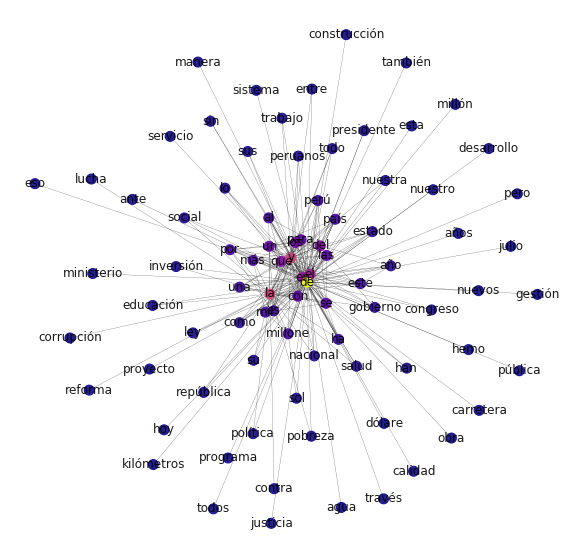

In [49]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(dcentralities.items(), key = lambda x : x[1])[1]
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = [dcentralities[n] / maxC for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

Checking the nodes colored in more intensive colors we see the more central ones!

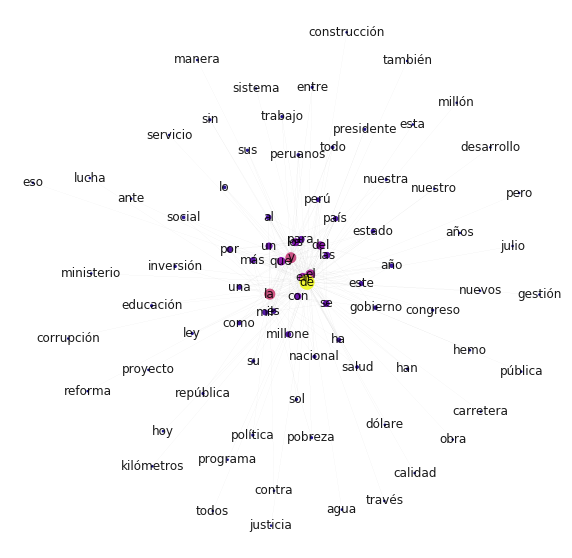

In [50]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(dcentralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gWord.edges(data = True)], 
        alpha = .9, 
        node_color = [dcentralities[n] / maxC for n in giant.nodes],
        node_size = [dcentralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

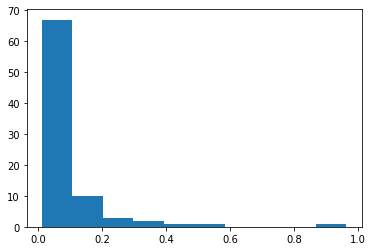

In [51]:
plt.hist(list(dcentralities.values()))
plt.show()

In [52]:
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('de', 0.9642857142857142),
 ('la', 0.4880952380952381),
 ('y', 0.47619047619047616),
 ('el', 0.369047619047619),
 ('en', 0.3214285714285714),
 ('que', 0.2738095238095238),
 ('del', 0.26190476190476186),
 ('los', 0.22619047619047616),
 ('un', 0.17857142857142855),
 ('con', 0.17857142857142855)]

In [53]:
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[-10:]

[('años', 0.011904761904761904),
 ('dólare', 0.011904761904761904),
 ('programa', 0.011904761904761904),
 ('lucha', 0.011904761904761904),
 ('obra', 0.011904761904761904),
 ('nuestro', 0.011904761904761904),
 ('justicia', 0.011904761904761904),
 ('sistema', 0.011904761904761904),
 ('millón', 0.011904761904761904),
 ('carretera', 0.011904761904761904)]

We now check the betweennes centrality and see that the distribution of important words regarding the degree cetrality doesn't change, but the least important ones do!

In [0]:
bcentralities = nx.betweenness.betweenness_centrality(giant)

In [68]:
bcentralities['programa']

0.0

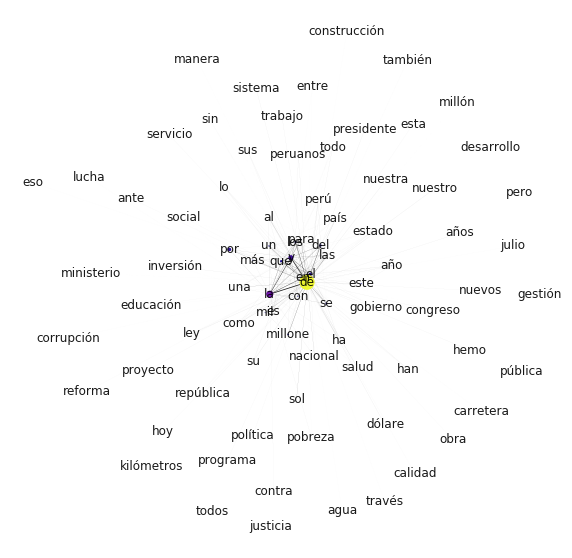

In [69]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(bcentralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant.edges(data = True)], 
        alpha = .9, 
        node_color = [bcentralities[n] / maxC for n in giant.nodes],
        node_size = [bcentralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

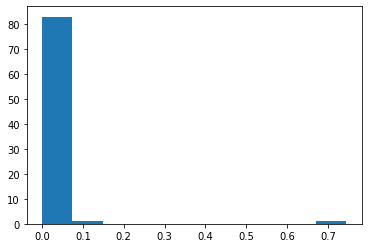

In [70]:
plt.hist(list(bcentralities.values()))
plt.show()

In [71]:
sorted(bcentralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('de', 0.7453003624475226),
 ('la', 0.13890983434873277),
 ('y', 0.059777317888333376),
 ('por', 0.02394612463459279),
 ('el', 0.01896645539072389),
 ('en', 0.009523923357830413),
 ('del', 0.00716892513364114),
 ('que', 0.006059726434080996),
 ('los', 0.0045338952180604495),
 ('se', 0.0030438078845996227)]

In [72]:
sorted(bcentralities.items(), key = lambda x: x[1], reverse = True)[50:60]

[('eso', 0.0),
 ('pública', 0.0),
 ('julio', 0.0),
 ('desarrollo', 0.0),
 ('las', 0.0),
 ('nuestra', 0.0),
 ('peruanos', 0.0),
 ('inversión', 0.0),
 ('través', 0.0),
 ('servicio', 0.0)]

The closeness centrality gives us a similar panorama

In [0]:
ccentralities = nx.closeness_centrality(giant)

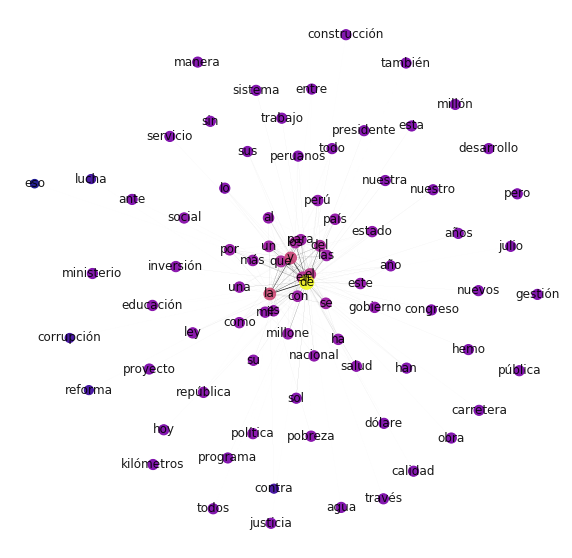

In [75]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(ccentralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant.edges(data = True)], 
        alpha = .9, 
        node_color = [ccentralities[n] / maxC for n in giant.nodes],
        node_size = [ccentralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

In [76]:
sorted(ccentralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('de', 0.9438202247191011),
 ('la', 0.6511627906976745),
 ('y', 0.6461538461538462),
 ('el', 0.60431654676259),
 ('en', 0.5874125874125874),
 ('que', 0.5714285714285714),
 ('del', 0.5637583892617449),
 ('los', 0.5562913907284768),
 ('se', 0.5419354838709678),
 ('un', 0.5419354838709678)]

In [77]:
sorted(ccentralities.items(), key = lambda x: x[1], reverse = True)[-10:]

[('nuestro', 0.4883720930232558),
 ('justicia', 0.4883720930232558),
 ('sistema', 0.4883720930232558),
 ('millón', 0.4883720930232558),
 ('carretera', 0.4883720930232558),
 ('corrupción', 0.39622641509433965),
 ('contra', 0.39622641509433965),
 ('reforma', 0.39622641509433965),
 ('lucha', 0.39622641509433965),
 ('eso', 0.34854771784232363)]

*With* eigenverctor centrality, we see that the relative importance doesn't change but the score is higher for this case. 



In [0]:
ecentralities = nx.eigenvector_centrality(giant)

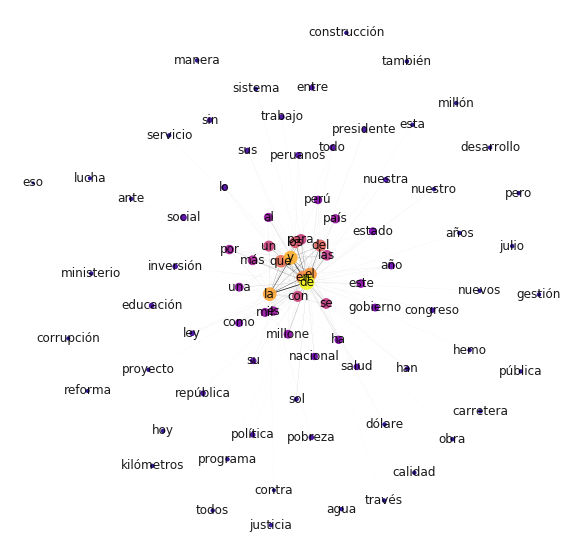

In [79]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(ecentralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant.edges(data = True)], 
        alpha = .9, 
        node_color = [ecentralities[n] / maxC for n in giant.nodes],
        node_size = [ecentralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

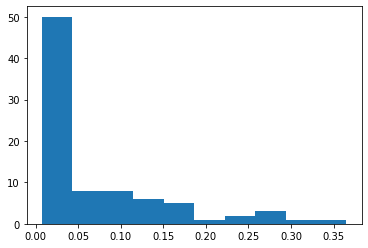

In [80]:
plt.hist(list(ecentralities.values()))
plt.show()

In [81]:
sorted(ecentralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('de', 0.3651191929614427),
 ('y', 0.30255799237856174),
 ('la', 0.2928186613279735),
 ('el', 0.27874202577833035),
 ('en', 0.26237975507914574),
 ('que', 0.23816349390953967),
 ('del', 0.2227445036195416),
 ('los', 0.20716946600247896),
 ('con', 0.18461949997218957),
 ('un', 0.1804484338148686)]

In [82]:
sorted(ecentralities.items(), key = lambda x: x[1], reverse = True)[-10:]

[('nuestro', 0.021301526695027963),
 ('justicia', 0.021301526695027963),
 ('sistema', 0.021301526695027963),
 ('millón', 0.021301526695027963),
 ('carretera', 0.021301526695027963),
 ('corrupción', 0.017083487219603028),
 ('contra', 0.017083487219603028),
 ('reforma', 0.017083487219603028),
 ('lucha', 0.017083487219603028),
 ('eso', 0.007641793066750875)]

We now filter the network and keep the words that meet a determined value according to a centrality meassure of our preference (or the one that is more according to our research).

In [0]:
def filterWords(G, minWeight = 3, filter_ = "betweenness", rule = "number", value_of_rule = 200):
    """Function to filter network by degree centrality measures"""
    G = G.copy()
    try:
        G.remove_edges_from([(n1,n2) for n1, n2, d in G.edges(data = True) if d['weight'] < minWeight])
    except:
        print("weight might be missing from one or more edges")
        raise
    if filter_ =="betweenness":
        index = nx.betweenness_centrality(G) #betweeness centrality score
    elif filter_ == "closeness":
        index = nx.closeness_centrality(G) #closeness centrality score
    elif filter_ == "eigenvector":
        index = nx.eigenvector_centrality(G) #eigenvector centrality score
    elif filter_ == "degree":
        index = nx.degree_centrality(G) #degree centrality score
    else:
        raise ValueError("wrong filter paremeter, should be: betweenness/closeness/eigenvector")    
        
    if rule=='number':# if filter by limiting the total number of nodes 
        
        sorted_index = sorted(index.items(), key=lambda x:x[1], reverse=True)
        value_of_rule = np.min([value_of_rule, len(G.nodes)])
        
        nodes_remain = {}
        for word, centr in sorted_index[:value_of_rule]:
            nodes_remain[word] = centr
        G.remove_nodes_from([n for n in index if n not in nodes_remain])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G
    
    if rule=='above':# if filter by limiting the min value of centrality
        value_of_rule = np.max([float(value_of_rule),0])
        G.remove_nodes_from([n for n in index if index[n] >=value_of_rule])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G
    
    if rule=='below':# if filter by limiting the max value of centrality
        value_of_rule = np.max([float(value_of_rule),0])
        G.remove_nodes_from([n for n in index if index[n] <=value_of_rule])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G

In [84]:
giant_filtered30 = filterWords(giant, minWeight=3, filter_='betweenness', rule='number', value_of_rule=25)
print(nx.info(giant_filtered30))

Total number of nodes(after filtering) in the graph is 25
Name: 
Type: Graph
Number of nodes: 25
Number of edges: 138
Average degree:  11.0400


Finally, we get the graph that matters to us with the most central words

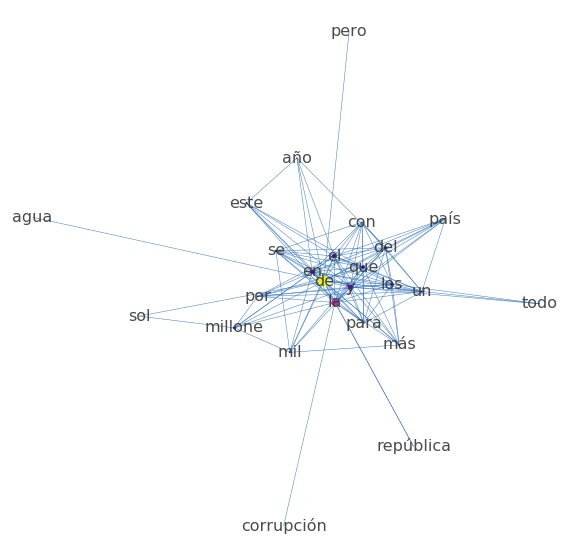

In [85]:
layout_giant_filtered30 = nx.spring_layout(giant_filtered30, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_giant30 = nx.betweenness_centrality(giant_filtered30)
maxC = max(centralities_giant30.items(), key = lambda x : x[1])[1]
nx.draw(giant_filtered30, ax = ax, pos = layout_giant_filtered30, labels = {n: n for n in giant_filtered30.nodes()},
        alpha = .9, 
        width = .5,
        node_color = [centralities_giant30[n] / maxC for n in giant_filtered30.nodes],
        node_size = [centralities_giant30[n] / maxC * 100 for n in giant_filtered30.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

In [86]:
nx.density(giant)

0.07759103641456583

In [87]:
np.mean([v for w,v in nx.degree(giant)])

6.517647058823529

In [88]:
nx.diameter(giant)

3

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">
Construct cells immediately below this that construct at least two different networks comprising different combinations of word types, linked by different syntactic structures, which illuminate your corpus and the dynamics you are interested to explore. Graph these networks or subnetworks within them. What are relationships that are meaningful?

Stretch: Graph some word-centered "ego-networks" with words one link away, two links away, and three links away (we only did up to two links away above)
